In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


# Importes

In [2]:
import random
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, log_loss, precision_score, recall_score, f1_score
from sklearn.preprocessing import RobustScaler
import xgboost as xgb

import wandb

## Funciones

Crearemos varias funciones que necesitaremos para la ejecución del modelo y la visualización de metricas y gráficas.

In [3]:
cmap = sns.cubehelix_palette(as_cmap=True)

In [4]:
def conf_matrix(y_true, y_pred, model_name):
  cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(f'Confusion Matrix - {model_name}')
  plt.show()

def roc(y_true, y_pred, model_name):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
  plt.legend(loc='lower right')
  plt.show()

def load_data():
  n = len(os.listdir('../data/business'))
  path = f'../data/business/breast_cancer_{n-1}';
  df = pd.read_parquet(path)
  return df

def transform_data(df):
  mapa = {'Maligno':1, 'Benigno':0}
  df['Diagnóstico'] = df['Diagnóstico'].map(mapa)
  return df

def set_seeds(n):
  np.random.seed(n)
  random.seed(n)
  torch.manual_seed(n)
  torch.cuda.manual_seed_all(n)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

def split(df):
  X = df.drop(columns='Diagnóstico')
  y = df['Diagnóstico']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
  return (X_train, X_test, y_train, y_test)

def normalize(X_train, X_test, y_train, y_test, scaler):
  X_train = torch.tensor(scaler.fit_transform(X_train.values), dtype=torch.float)
  y_train = torch.tensor((y_train.values), dtype=torch.float).unsqueeze(1)

  X_test = torch.tensor(scaler.fit_transform(X_test.values), dtype=torch.float)
  y_test = torch.tensor(y_test.values, dtype=torch.float).unsqueeze(1)

  return (X_train, X_test, y_train, y_test)

def predict_diagnosis(model, data, threshold = 0.45):
    prediction = model.predict_proba(data)[:, 1] # Probabilidad de que sea maligno (1)
    return (prediction >= threshold).astype(int)

def hyperparameters_tuning(model ,X, y):
  param_grid = {
      'n_estimators': [100, 200, 300],
      'criterion': ['gini', 'entropy'],
      'max_depth': [None, 10, 20],
      'max_features': ['auto', 'sqrt', 'log2'],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4]
  }

  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
  grid_search.fit(X, y)

  print("Mejores hiperparámetros:", grid_search.best_params_)

  print("Puntuación del mejor modelo:", grid_search.best_score_)

  return grid_search.best_params_

def save_model(model, name):
  with open(f'{name}.pkl', 'wb') as file:
    pickle.dump(model, file)

# Ejecución

Vamos a comenzar con cargar el dataset.

In [5]:
from google.colab import drive;
drive.mount('/content/drive');
ruta_archivo = '/content/drive/MyDrive/dataset/breastcancer/breast_cancer.parquet';

Mounted at /content/drive


In [11]:
df = pd.read_parquet(ruta_archivo)

In [ ]:
df = load_data()

Ahora es necesario transformarlo para que todos los datos sean numéricos.

In [12]:
df = transform_data(df)

## Visualización

Como podemos comprobar ahora todas las columnas contienen valores númericos.

In [13]:
df.head()

,Diagnóstico,Radio medio,Textura media,Perímetro medio,Área media,Suavidad media,Compacidad media,Concavidad media,Puntos cóncavos medios,Simetría media,...,Peor radio,Peor textura,Peor perímetro,Peor área,Peor suavidad,Peor compacidad,Peor concavidad,Peor puntuación de los puntos cóncavos,Peor simetría,Peor dimensión fractal
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Diagnóstico                             569 non-null    int64  
 1   Radio medio                             569 non-null    float64
 2   Textura media                           569 non-null    float64
 3   Perímetro medio                         569 non-null    float64
 4   Área media                              569 non-null    float64
 5   Suavidad media                          569 non-null    float64
 6   Compacidad media                        569 non-null    float64
 7   Concavidad media                        569 non-null    float64
 8   Puntos cóncavos medios                  569 non-null    float64
 9   Simetría media                          569 non-null    float64
 10  Dimensión fractal media                 569 non-null    float6

### Distribución de las variables

Como podemos ver en el histograma, mayoritariamente existe una asimetría negativa en la distribución de las variables.

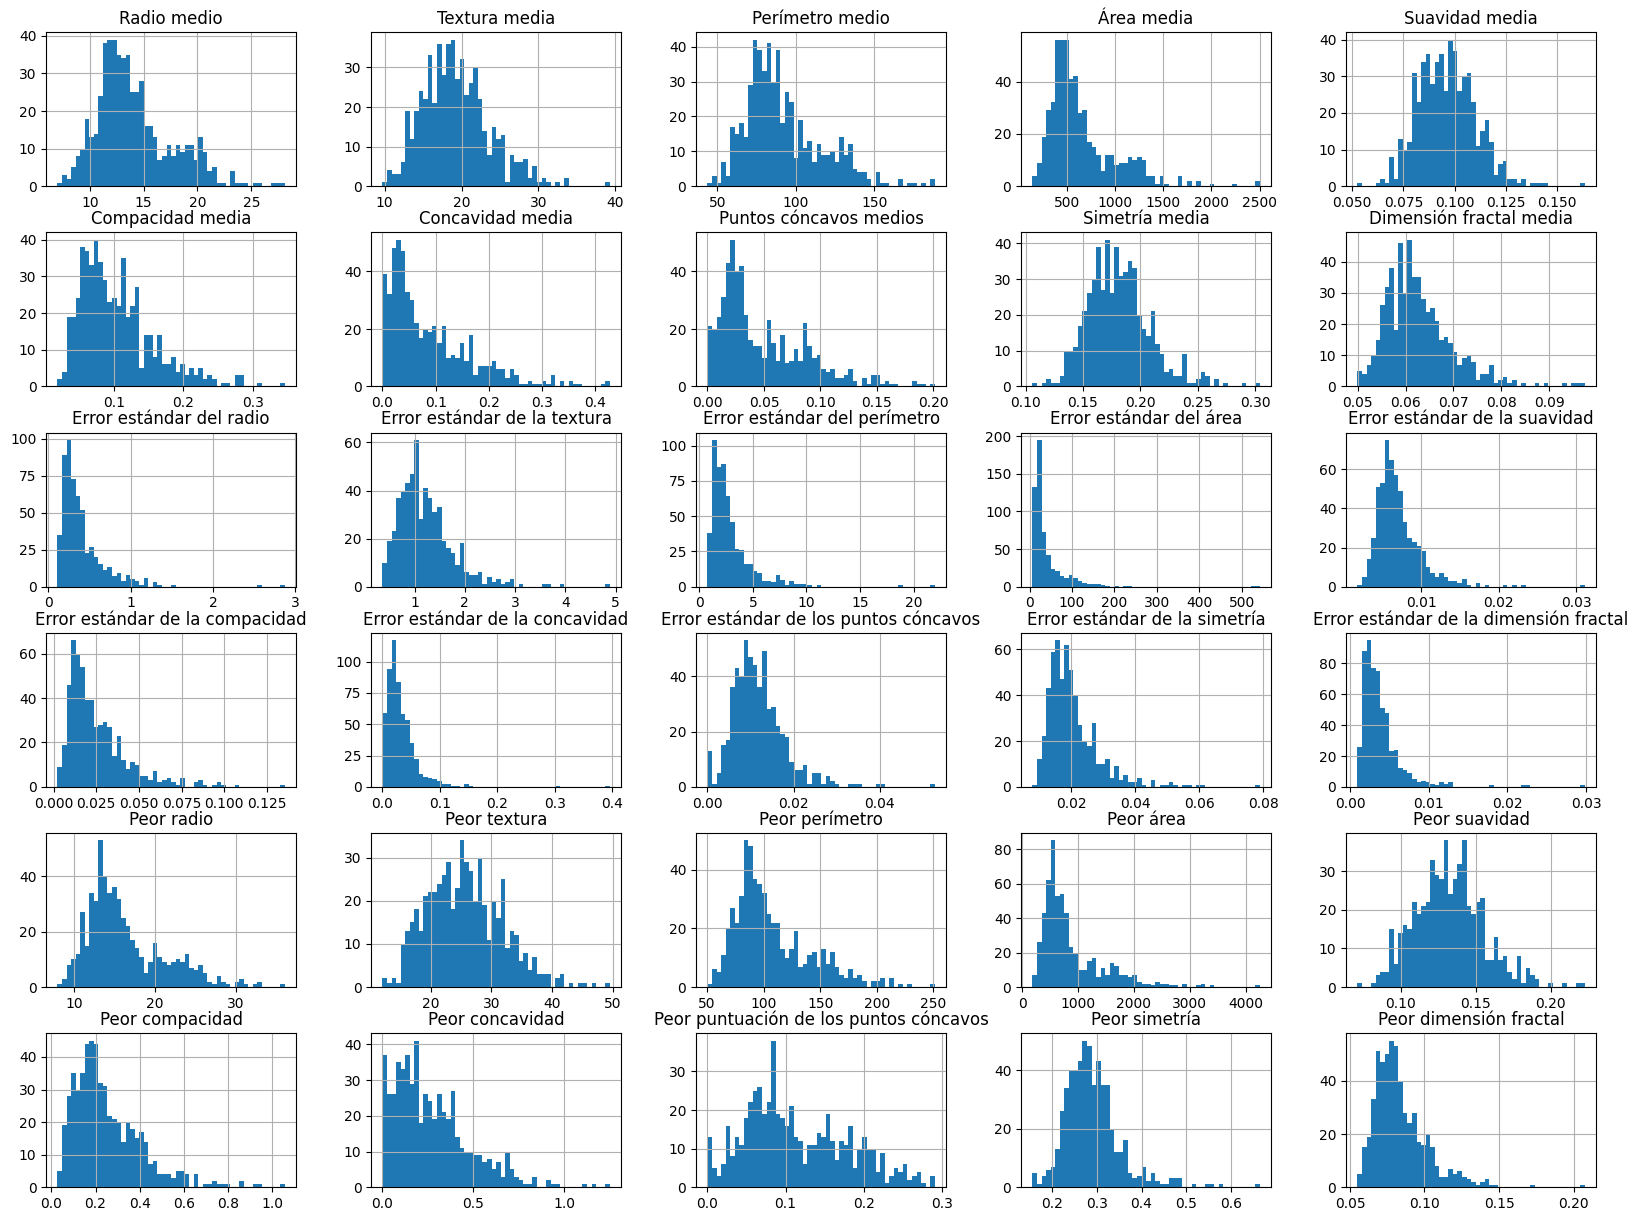

In [15]:
df[df.columns[1:].tolist()].hist(bins=50, figsize=(20,15));
plt.show();

### Estudio de Correlaciones

Echandole un vistazo a las correlaciones entre las variables podemos ver que todas ellas están altamente relacionadas, no todas directamente, pero sí indirectamente.

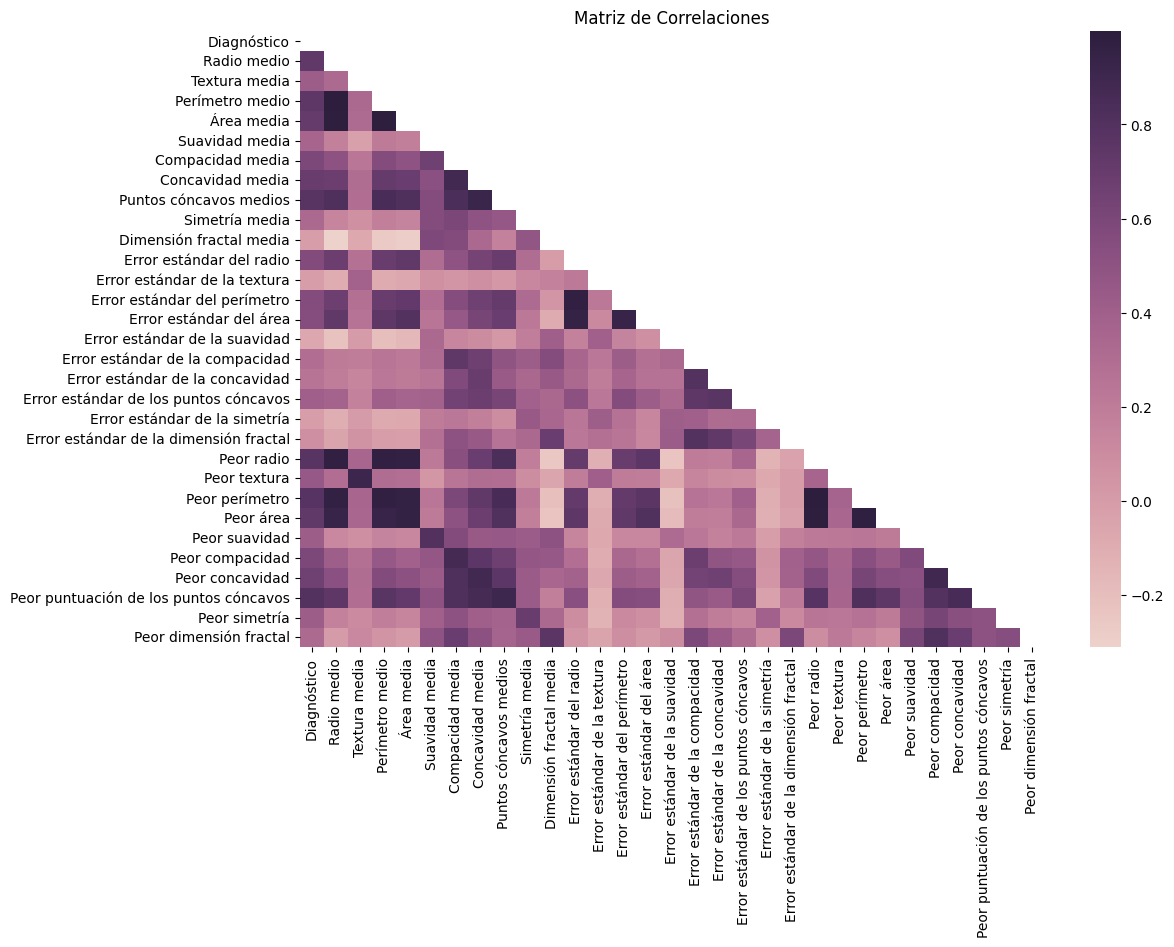

In [16]:
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap=cmap, fmt='.2f', mask=mask)
plt.title('Matriz de Correlaciones')
plt.show()

Si nos centramos únicamente en la columna Diagnóstico, que es la que más tarde queremos predecir, podemos observar que la mitad de las columnas tienen una correlación positiva de más de un 50%, y también el otro cuarto restante aún guarda una correlación entre el 40% y 20%.

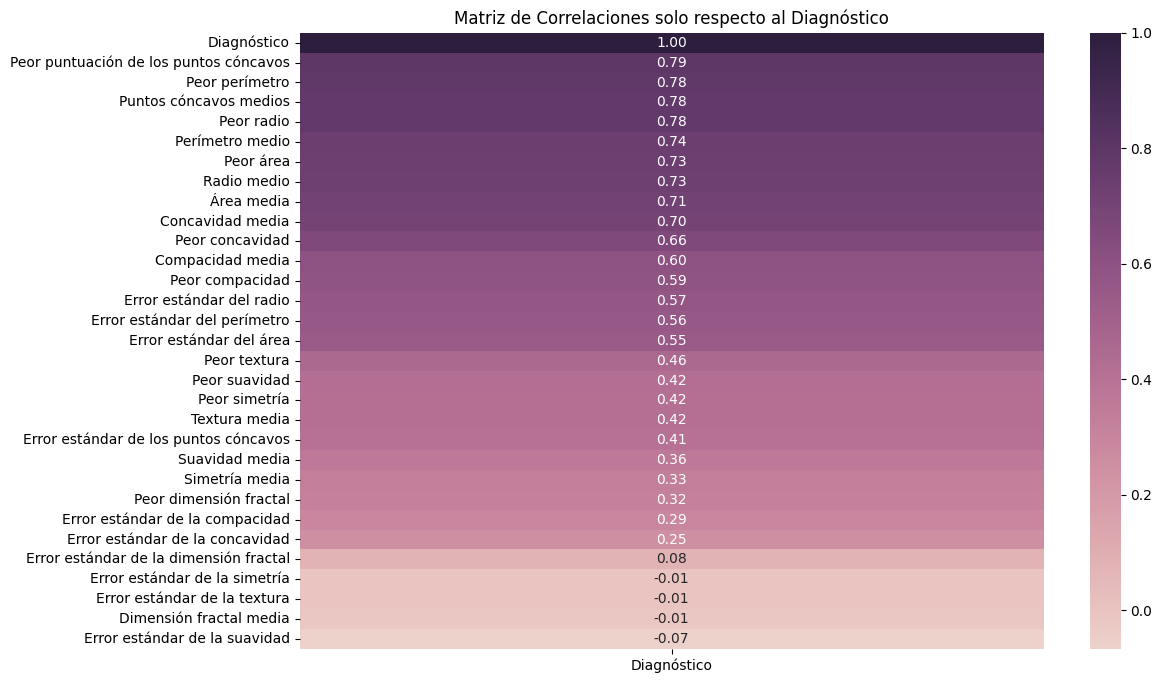

In [17]:
sorted_corr = df.corr()['Diagnóstico'].sort_values(ascending=False)
sorted_corr_matrix = correlation_matrix.loc[sorted_corr.index, sorted_corr.index]

# Mostrar el heatmap con las correlaciones ordenadas
plt.figure(figsize=(12, 8))
sns.heatmap(sorted_corr_matrix[['Diagnóstico']], annot=True, cmap=cmap, fmt='.2f')
plt.title('Matriz de Correlaciones solo respecto al Diagnóstico')
plt.show()

Con unas correlaciones tan grandes entre todas las columnas, es mejor no optar por una reducción de dimensionalidad, ya que corremos el risgo de perder información crítica y sustancial.

## Entrenamiento y predicción

Definimos todas las seed para que el entrenamiento y predicción de los modelos pueda ser todo lo reproducible posible.

In [18]:
set_seeds(42)

Creamos los conjuntos de datos train y test

In [19]:
X_train, X_test, y_train, y_test = split(df)

## Modelos

### Random Forest

Para el Random Forest haremos una búsqueda de hiperparámetros y especificaremos un umbral de 0.4

In [20]:
rf_model = RandomForestClassifier(random_state=42)

In [21]:
best_params = hyperparameters_tuning(rf_model, X_train, y_train)

wandb.init(project='BrestCancer_Model', entity='vapepa',
    config={
    "dataset": "Breast Cancer", "best params": best_params
    })

rf_model = RandomForestClassifier(**best_params ,random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = predict_diagnosis(rf_model, X_test, threshold=0.4)

accuracy = accuracy_score(y_test, y_pred_rf)
loss = log_loss(y_test, y_pred_rf)

print("Random Forest Classifier:")
print(f"Precisión: {accuracy:.2f}")
print(classification_report(y_test, y_pred_rf))

wandb.log({'loss': loss.item(), 'accuracy': accuracy,
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1-score': f1_score(y_test, y_pred_rf)
})
wandb.save('model.pth')
wandb.finish()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Puntuación del mejor modelo: 0.9621835443037975


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Random Forest Classifier:
Precisión: 0.98
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       107
           1       1.00      0.95      0.98        64

    accuracy                           0.98       171
   macro avg       0.99      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



accuracy,▁
f1-score,▁
loss,▁
precision,▁
recall,▁
accuracy,0.98246
f1-score,0.976
loss,0.63234
precision,1.0
recall,0.95312


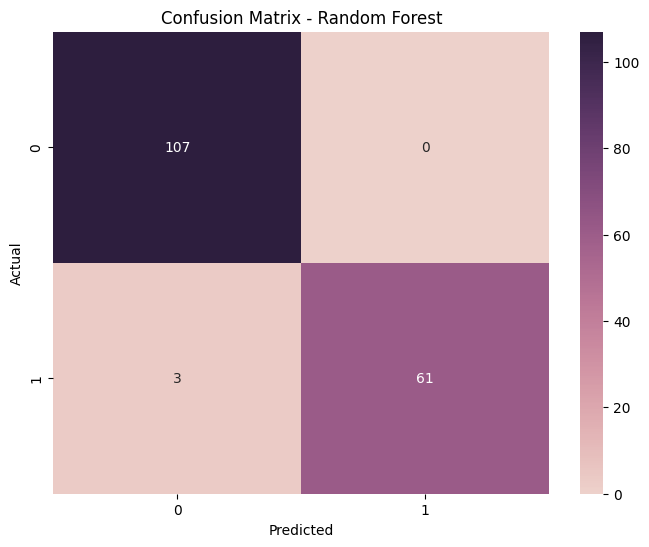

In [22]:
conf_matrix(y_test, y_pred_rf, 'Random Forest')

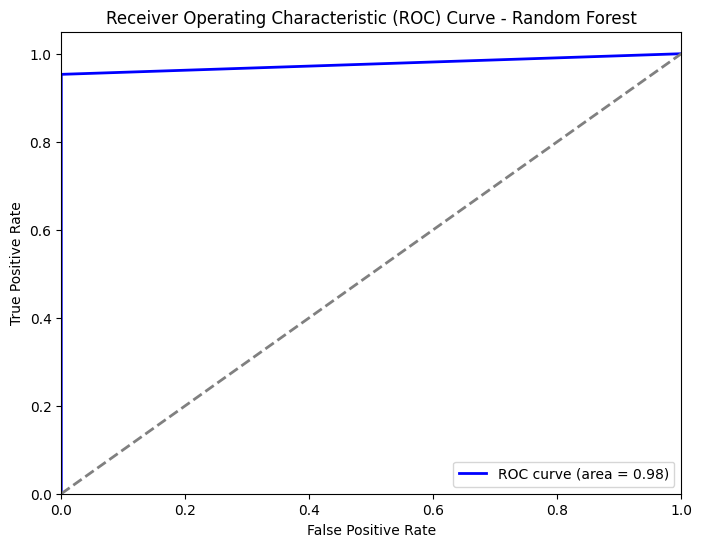

In [23]:
roc(y_test, y_pred_rf, 'Random Forest')

In [33]:
save_model(rf_model, 'model_rf')

### XGBoost

In [37]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.5,
    'colsample_bytree': 0.8,
    'gamma': 1,
    'min_child_weight': 1,
    'lambda': 1,
    'alpha': 1
}

wandb.init(project='BrestCancer_Model', entity='vapepa',
    config={
        "dataset": "Breast Cancer",
        "best params": params
    })

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

num_boost_round = 400
xgb_model = xgb.train(params, dtrain, num_boost_round)

y_pred_proba = xgb_model.predict(dtest)
y_pred_xgb = [1 if prob > 0.35 else 0 for prob in y_pred_proba]


accuracy = accuracy_score(y_test, y_pred_xgb)
loss = log_loss(y_test, y_pred_proba)

print("XGBoost Classifier:")
print(f"Precisión: {accuracy:.2f}")
print(classification_report(y_test, y_pred_xgb))

wandb.log({
    'loss': loss,
    'accuracy': accuracy,
    'precision': precision_score(y_test, y_pred_xgb),
    'recall': recall_score(y_test, y_pred_xgb),
    'f1-score': f1_score(y_test, y_pred_xgb)
})

xgb_model.save_model('model.json')
wandb.save('model.json')

wandb.finish()

XGBoost Classifier:
Precisión: 0.99
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       107
         1.0       1.00      0.97      0.98        64

    accuracy                           0.99       171
   macro avg       0.99      0.98      0.99       171
weighted avg       0.99      0.99      0.99       171



accuracy,▁
f1-score,▁
loss,▁
precision,▁
recall,▁
accuracy,0.9883
f1-score,0.98413
loss,0.07117
precision,1.0
recall,0.96875


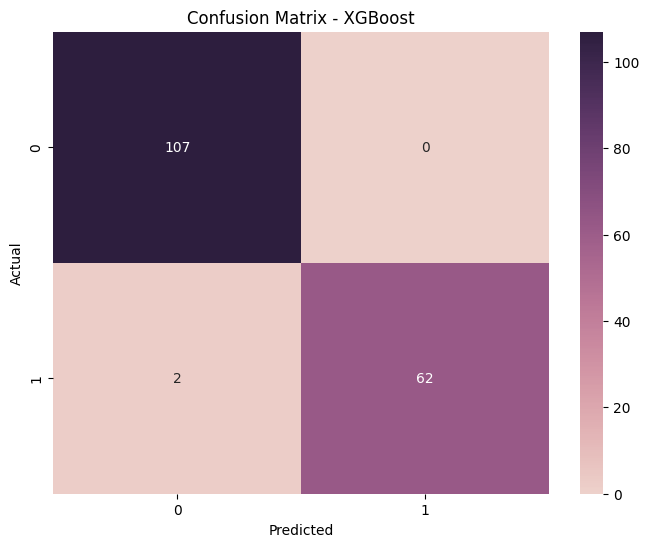

In [38]:
conf_matrix(y_test, y_pred_xgb, 'XGBoost')

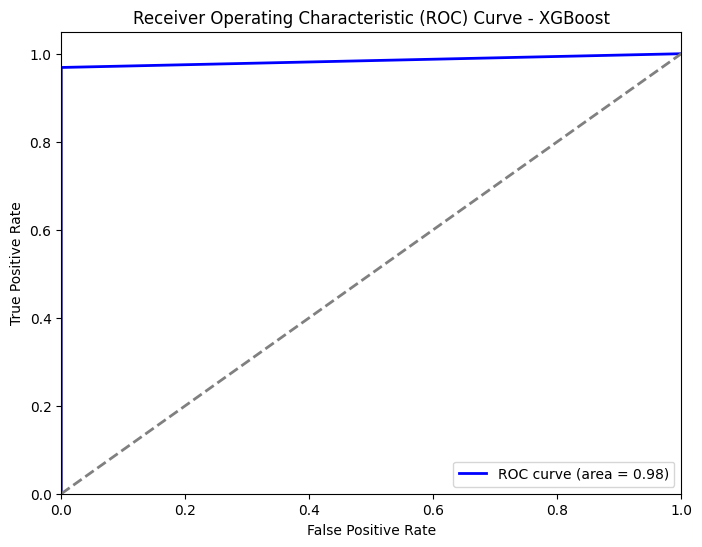

In [40]:
roc(y_test, y_pred_xgb, 'XGBoost')

In [42]:
save_model(xgb_model, 'model_xgb')

### Red Neuronal

Las redes neuronales necesitan de tensores para trabajar, así que lo primero que vamos hacer es convertir nuestros conjuntos de datos a tensores.

Y también normalizaremos los datos.

In [27]:
scaler = RobustScaler()
X_train, X_test, y_train, y_test = normalize(X_train, X_test, y_train, y_test, scaler)

La Red Neuronal que hemos diseñado cuenta con 2 capas ocultas a las cuales se le aplica la función de activación relu, que hace que retorne 0 si el valore de entrada es negativo e introduce la no linealidad. La segunda capa oculta también cuenta con un dropout con probabilidad de 20% de apagar la neurona, con esto nos aseguramos de minimizar el Overfitting.

La capa de activación de la última capa utiliza sigmoid, ya que esta mapea cualquier valor real a valores de un rango entre 0 y 1, y para un problema de clasificación binaria como este es el más adecuado.

In [28]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(30, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

La función de pérdida utilizada es BCELoss (Binary Cross-Entropy Loss) la cual es comunmente utilizada en problemas de clasificación binaria, cuando se quiere averiguar si un valor pertenece a una clase o no.

El Optimizador que utilizamos es RMSprop (Root Mean Square Propagation) calcula una tasa de aprendizaje adaptativa para cada parámetro como la raíz cuadrada de la media exponencialmente ponderada de los cuadrados de los gradientes anteriores. La actualización de los parámetros se realiza entonces dividiendo el gradiente actual por esta tasa de aprendizaje adaptativa.

Lo hemos elegido por mera pura prueba y error, y al haber observado que es el que mejor eficacia mostraba.

In [29]:
wandb.init(project='BrestCancer_Model', entity='vapepa',
    config={
    "learning_rate": 0.0001,
    "weight_decay": 0.001,
    "architecture": "NN",
    "dataset": "Breast Cancer",
    "epochs": 5000,
    })

model_nn = NeuralNetwork()

criterion = nn.BCELoss()
optimizer = optim.RMSprop(model_nn.parameters(), lr=0.0001, weight_decay=0.001)

epochs = 5000
model_nn.train()
for epoch in range(epochs):
    outputs = model_nn(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

model_nn.eval()
y_pred_nn = model_nn(X_test)
y_pred_nn = y_pred_nn.detach().numpy().round()

accuracy = accuracy_score(y_test, y_pred_nn)

print("Red Neuronal:")
print(f"Precisión: {accuracy:.2f}")
print(classification_report(y_test, y_pred_nn))

wandb.log({'loss': loss.item(), 'accuracy': accuracy,
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1-score': f1_score(y_test, y_pred_rf)})
wandb.watch(model_nn)
torch.save(model_nn.state_dict(), 'model.pth')
wandb.save('model.pth')
wandb.finish()

Epoch [100/5000], Loss: 0.6362
Epoch [200/5000], Loss: 0.5836
Epoch [300/5000], Loss: 0.5349
Epoch [400/5000], Loss: 0.4850
Epoch [500/5000], Loss: 0.4336
Epoch [600/5000], Loss: 0.3883
Epoch [700/5000], Loss: 0.3444
Epoch [800/5000], Loss: 0.2924
Epoch [900/5000], Loss: 0.2654
Epoch [1000/5000], Loss: 0.2300
Epoch [1100/5000], Loss: 0.2095
Epoch [1200/5000], Loss: 0.1938
Epoch [1300/5000], Loss: 0.1584
Epoch [1400/5000], Loss: 0.1443
Epoch [1500/5000], Loss: 0.1303
Epoch [1600/5000], Loss: 0.1192
Epoch [1700/5000], Loss: 0.1044
Epoch [1800/5000], Loss: 0.0988
Epoch [1900/5000], Loss: 0.0842
Epoch [2000/5000], Loss: 0.0834
Epoch [2100/5000], Loss: 0.0746
Epoch [2200/5000], Loss: 0.0685
Epoch [2300/5000], Loss: 0.0648
Epoch [2400/5000], Loss: 0.0574
Epoch [2500/5000], Loss: 0.0573
Epoch [2600/5000], Loss: 0.0448
Epoch [2700/5000], Loss: 0.0458
Epoch [2800/5000], Loss: 0.0384
Epoch [2900/5000], Loss: 0.0413
Epoch [3000/5000], Loss: 0.0377
Epoch [3100/5000], Loss: 0.0357
Epoch [3200/5000]

accuracy,▁
f1-score,▁
loss,▁
precision,▁
recall,▁
accuracy,0.98246
f1-score,0.976
loss,0.01059
precision,1.0
recall,0.95312


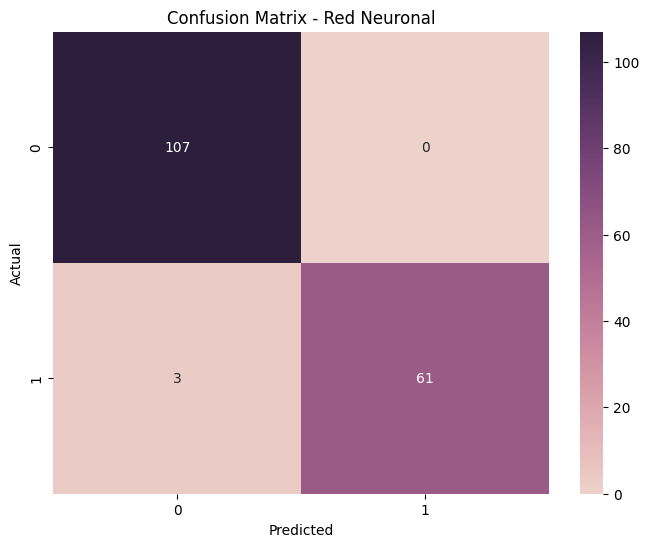

In [30]:
conf_matrix(y_test, y_pred_nn, 'Red Neuronal')

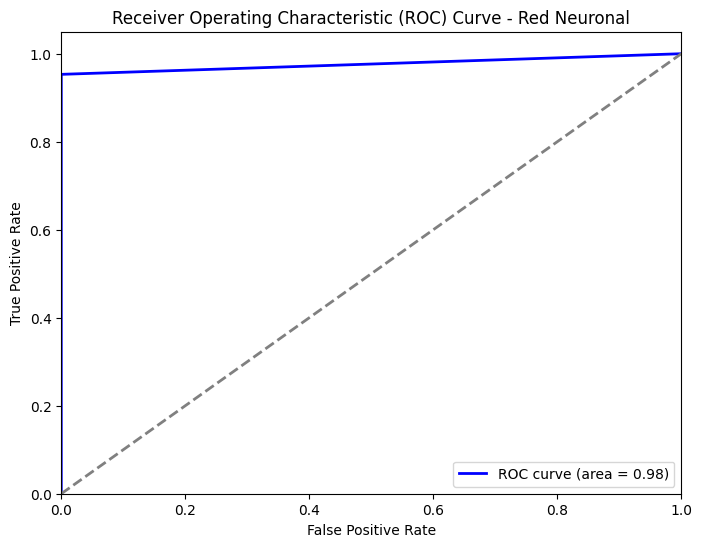

In [31]:
roc(y_test, y_pred_nn, 'Red Neuronal')

La Red Neuronal arroja mejores resultados, así que será el modelo que elegiremos para nuestras predicciones.

In [32]:
save_model(model_nn, 'model_nn')